In [1]:
# 风险及免责提示：该策略由聚宽用户在聚宽社区分享，仅供学习交流使用。
# 原文一般包含策略说明，如有疑问请到原文和作者交流讨论。
# 原文网址：https://www.joinquant.com/view/community/detail/28963
# 标题：【分享】对RSRS模型的一次修改

# 引入库
import tushare as ts

# 标记交易时点
import talib
import numpy as np
import pandas as pd

import statsmodels.api as sm  # 线性回归

import pyfolio as pf  # 组合分析工具
from Creat_RSRS import (RSRS,rolling_apply)  # 自定义信号生成


import itertools  # 迭代器工具


# 画图
import matplotlib.pyplot as plt
import seaborn as sns

# 设置字体 用来正常显示中文标签
plt.rcParams['font.family'] = 'serif'
#mpl.rcParams['font.sans-serif'] = ['SimHei']

# 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False
# 图表主题
plt.style.use('seaborn')

pro = ts.pro_api('your token')

# 数据获取及回测用函数

In [28]:
def query_index_data(ts_code: str, start: str, end: str, fields: str) -> pd.DataFrame:
    
    '''获取指数行情数据'''

    df = pro.index_daily(ts_code=ts_code, start_date=start,
                         end_date=end, fields='ts_code,trade_date,'+fields)
    
    df['trade_date'] = pd.to_datetime(df['trade_date'])
    
    df.set_index('trade_date', inplace=True)
    df.sort_index(inplace=True)

    return df


# 持仓标记
def add_flag(signal_ser: pd.Series, S: float) -> pd.DataFrame:
    '''
    开平仓标记 
        1-open/hold 0-close
        signal_ser:index-date values-RSRS
        S:阈值
    '''

    flag = pd.Series(np.zeros(len(signal_ser)), index=signal_ser.index)

    pre_day = signal_ser.index[0]

    for trade, signal in signal_ser.items():

        if signal > S:

            flag[trade] = 1

        elif signal < -S:

            flag[trade] = 0

        else:

            flag[trade] = flag[pre_day]

        pre_day = trade

    return flag


def creat_algorithm_returns(signal_df: pd.DataFrame, benchmark_ser: pd.Series, S: float) -> tuple:
    '''生成策略收益表'''

    flag_df = signal_df.apply(lambda x: add_flag(x, S))

    log_ret = np.log(benchmark_ser / benchmark_ser.shift(1))  # 获取对数收益率

    next_ret = log_ret.shift(-1)  # 获取next_ret

    # 策略收益
    algorithm_ret = flag_df.apply(lambda x: x * next_ret)

    # 使用pyfolio分析格式化index
    algorithm_ret = algorithm_ret.tz_localize('UTC')
    algorithm_ret = algorithm_ret.dropna()

    benchmark = log_ret.tz_localize('UTC').reindex(algorithm_ret.index)

    return algorithm_ret, benchmark


def view_nav(algorithm_ret: pd.DataFrame, benchmark_ser: pd.Series):
    '''画净值图'''
    
    plt.rcParams['font.family'] = 'Microsoft JhengHei'
    # 策略净值
    algorithm_cum = (1 + algorithm_ret).cumprod()

    benchmark = (1 + benchmark_ser).cumprod()

    benchmark = benchmark.reindex(algorithm_cum.index)

    algorithm_cum.plot(figsize=(18, 8))  # 画图
    benchmark.plot(label='benchmark', ls='--', color='black')
    plt.legend()

def view_signal(close_ser: pd.Series, signal_ser: pd.Series):

    '''查看信号与指数的关系'''
    
    plt.rcParams['font.family'] = 'Microsoft JhengHei'
    close_ser = close_ser.reindex(signal_ser.index)
    plt.figure(figsize=(18, 8))
    close_ser.plot(color='Crimson')
    plt.ylabel('收盘价')
    plt.legend(['close'], loc='upper left')

    plt.twinx()
    signal_ser.plot()
    plt.ylabel('信号')
    plt.legend([signal_ser.name], loc='upper right')

## 数据结构

In [3]:
# 日行情数据获取
fields = ['close', 'pre_close', 'high', 'low', 'money']

close_df = query_index_data('000300.SH', '20090101',
                            '20200813', 'close,pre_close,high,low,amount')


close_df.rename(columns={'amount': 'money'}, inplace=True)

close_df.head()

,ts_code,close,high,low,pre_close,money
trade_date,,,,,,
2009-01-05,000300.SH,1882.959,1882.959,1837.839,1817.722,3.921708e+07
2009-01-06,000300.SH,1942.795,1948.489,1873.011,1882.959,5.926217e+07
2009-01-07,000300.SH,1931.178,1959.246,1930.868,1942.795,5.014342e+07
2009-01-08,000300.SH,1887.991,1902.796,1873.648,1931.178,4.721080e+07
2009-01-09,000300.SH,1918.365,1923.423,1886.488,1887.991,4.151121e+07


# RSRS指标回顾

RSRS为最基础的原始信号,衍生指标分别有:
- RSRS_z RSRS标准分
- RSRS_revise RSRS修正标准分
- RSRS_negative_r RSRS修正右偏标准分
- RSRS_passivation 钝化RSRS

RSRS计算方式分别由OLS回归和WLS回归(成交量加权)

2019年光大证券更新了RSRS的计算公式,使得RSRS(这里的RSRS指的是**RSRS_passivation**)能过更好的对抗震荡行情:

$$RSRS=z\_score(\hat{\beta})*R^{4*quantile(std(returns),M)}$$

>由于𝑅大于0小于1，当分位数越大时，震荡水平越高，此时RSRS指标将得到更大的钝化效果。

但是中国市场往往是波动率高的时候挣钱效应明显,低波动反而不行。所以实际情况应该与模型假设相反，为了验证我的想法,我将指数部分的分位数反向构造使用钝化器为：`1-quantile`(即高波动时RSRS_passivation大，低波动时RSRS_passivation小)

---

**对比区间为:2011-07-15至2020-08-13**

**使用OLS回归计算RSRS,参数设置为N=16,M=600**


## 获取原始RSRS_passivation指标

In [4]:
rsrs = RSRS()  # 调用RSRS计算类
signal_df = rsrs.get_RSRS(close_df, 16, 600, 'ols')  # 获取各RSRS信号

signal_df.head()

,RSRS,RSRS_z,RSRS_revise,RSRS_negative_r,RSRS_passivation
2011-07-15,0.709707,-1.444057,-1.249089,-0.886487,-1.379898
2011-07-18,0.866042,-0.149527,-0.140540,-0.121714,-0.148296
2011-07-19,0.838022,-0.379350,-0.351060,-0.294196,-0.374772
2011-07-20,0.796764,-0.718349,-0.654648,-0.521600,-0.707536
2011-07-21,0.745605,-1.138971,-0.996965,-0.743342,-1.117933


原始RSRS_passivation信号2011-07-15至2020-08-13年化波动率为15.6%,夏普0.81,最大回撤为-21%

Start date,2011-07-15
End date,2020-08-13
Total months,105
,Backtest
Annual return,12.2%
Cumulative returns,174.0%
Annual volatility,15.6%
Sharpe ratio,0.81
Calmar ratio,0.58
Stability,0.88
Max drawdown,-21.0%


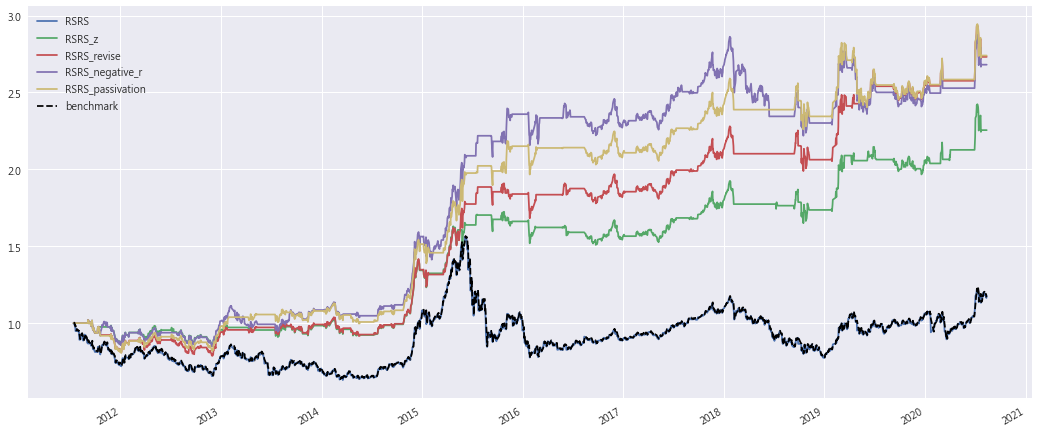

In [5]:
algorithm_ret, benchmark = creat_algorithm_returns(
    signal_df, close_df['close'], 0.7)

view_nav(algorithm_ret, benchmark)

pf.plotting.show_perf_stats(algorithm_ret['RSRS_passivation'],
                            benchmark)

## 按照猜想改造钝化器

In [6]:
class RSRS_improve1(RSRS):

    # 重写RSRS钝化指标
    @staticmethod
    def cala_passivation_RSRS(df: pd.DataFrame, ret_quantile: pd.Series) -> pd.DataFrame:
        '''
        钝化RSRS
            df:index-date columns - |RSRS_z|R_2|
            ret_quantile:收益波动率百分位
        '''

        df['RSRS_passivation'] = df['RSRS_z'] * \
            np.power(df['R_2'], 2 * (1 - ret_quantile.reindex(df.index)))

        return df

In [7]:
rsrs = RSRS_improve1() # 调用RSRS计算类
signal_df = rsrs.get_RSRS(close_df,16,600,'ols') # 获取各RSRS信号

signal_df.head()

,RSRS,RSRS_z,RSRS_revise,RSRS_negative_r,RSRS_passivation
2011-07-15,0.709707,-1.444057,-1.249089,-0.886487,-1.130679
2011-07-18,0.866042,-0.149527,-0.140540,-0.121714,-0.133190
2011-07-19,0.838022,-0.379350,-0.351060,-0.294196,-0.328849
2011-07-20,0.796764,-0.718349,-0.654648,-0.521600,-0.605712
2011-07-21,0.745605,-1.138971,-0.996965,-0.743342,-0.889086


改造后的RSRS_passivation信号2011-07-15至2020-08-13年化波动率由15.6%降为15.1%,夏普从0.81提升至0.87,最大回撤由-21%降低为-20.7%,虽然各项风险指标提升不多但证明思路也许是对的。

初步结论：**通过波动率百分位识别震荡可能过于简单而我们把模型中的$quantile(std(ret),M)$看作是震荡过滤器的话,将其替换为数据范围在0~1的一个震荡过滤指标,可能会对回撤有提升效果**

Start date,2011-07-15
End date,2020-08-13
Total months,105
,Backtest
Annual return,12.7%
Cumulative returns,186.1%
Annual volatility,15.1%
Sharpe ratio,0.87
Calmar ratio,0.61
Stability,0.92
Max drawdown,-20.7%


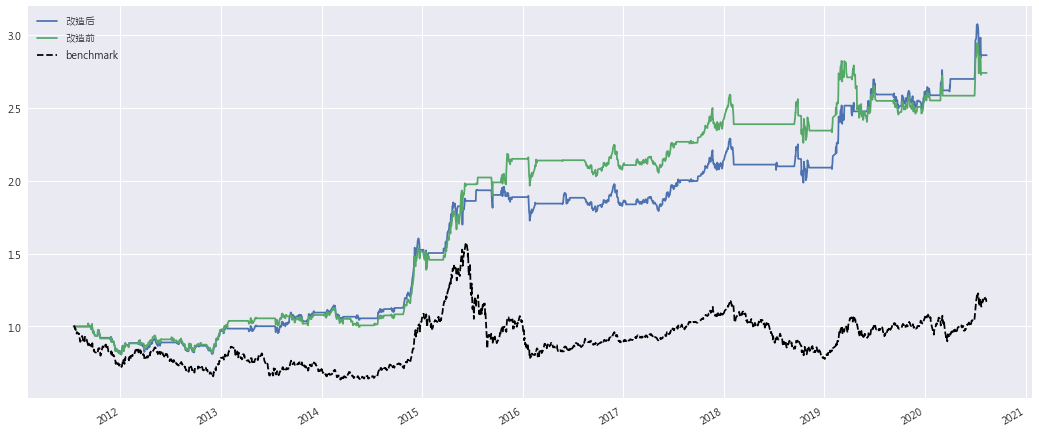

In [8]:
algorithm_ret_ver1, benchmark = creat_algorithm_returns(
    signal_df, close_df['close'], 0.7)

compare_df = pd.concat([algorithm_ret_ver1['RSRS_passivation'],
                        algorithm_ret['RSRS_passivation']], axis=1)
compare_df.columns = ['改造后', '改造前']

view_nav(compare_df, benchmark)

pf.plotting.show_perf_stats(algorithm_ret_ver1['RSRS_passivation'],
                            benchmark)

# 使用LR指标当作震荡过滤器


**LR指标概述**

1. 当LR处于0.4~0.6范围之内时，我们认为此时价格的趋势不明朗，处于震荡区间;
2. 当LR大于0.6时，认为价格的趋势是向上的，并且LR指标值越大，向上的趋势就越强；
3. 当LR小于0.4时，认为价格的趋势是向下的，并且LR指标值越小，向下的趋势就越强。

In [12]:
# LR指标
def cala_LR(close: pd.Series) -> pd.Series:
    '''
    close：index-date value-close
    '''
    periods = list(range(10, 250, 10))
    ma = pd.concat([close.rolling(i).mean() for i in periods], axis=1)
    ma.columns = periods
    ma = ma.dropna()

    return ma.apply(lambda x: np.mean(np.where(close.loc[x.name] > x, 1, 0)), axis=1)


class RSRS_improve2(RSRS):

    # 重写方法 加入ls过滤器
    def get_RSRS(self, df: pd.DataFrame, LR_ser: pd.Series, N: int, M: int, method: str) -> pd.DataFrame:
        '''
        计算各类RSRS

            df:index-date columns-|close|high|low|money|pre_close|
            N:计算RSRS
            M:修正标准分所需参数
            method:选择 ols 或 wls 回归
        '''
        selects = {'ols': (df, lambda x: self._cala_ols(x, 'low', 'high'), N),
                   'wls': (df, lambda x: self._cala_wls(x, 'low', 'high', 'money'), N)}

        ret_quantile = LR_ser.rolling(M).apply(
            lambda x: x.rank(pct=True)[-1], raw=False)

        rsrs_df = rolling_apply(*selects[method])  # 计算RSRS

        res_df = (rsrs_df.pipe(self.cala_RSRS_z, M)
                  .pipe(self.cala_revise_RSRS)
                  .pipe(self.cala_negative_revise_RSRS)
                  .pipe(self.cala_passivation_RSRS, ret_quantile))

        return res_df.drop(columns='R_2').iloc[M:]

In [14]:
# 获取计算lr所需数据
price_df = query_index_data('000300.SH', '20080101', '20200813', 'close')

# 指标计算
LR = cala_LR(price_df['close'])

In [23]:
rsrs = RSRS_improve2()  # 调用RSRS计算类
signal_df = rsrs.get_RSRS(close_df, (1 - LR), 16, 600, 'ols')  # 获取各RSRS信号

signal_df.head()

,RSRS,RSRS_z,RSRS_revise,RSRS_negative_r,RSRS_passivation
2011-07-15,0.709707,-1.444057,-1.249089,-0.886487,-1.185254
2011-07-18,0.866042,-0.149527,-0.140540,-0.121714,-0.137141
2011-07-19,0.838022,-0.379350,-0.351060,-0.294196,-0.336063
2011-07-20,0.796764,-0.718349,-0.654648,-0.521600,-0.621379
2011-07-21,0.745605,-1.138971,-0.996965,-0.743342,-0.918979


更改过滤器后的RSRS_passivation信号2011-07-15至2020-08-13年化波动率由15.6%降为15.2%,夏普从0.81提升至0.91,最大回撤由-21%降至-17.5%

Start date,2011-07-15
End date,2020-08-13
Total months,105
,Backtest
Annual return,13.4%
Cumulative returns,201.8%
Annual volatility,15.2%
Sharpe ratio,0.91
Calmar ratio,0.77
Stability,0.93
Max drawdown,-17.5%


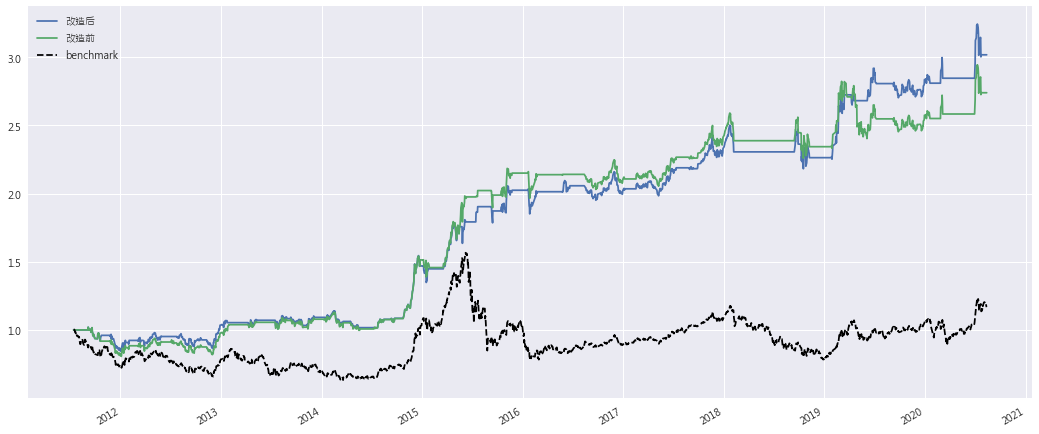

In [24]:
algorithm_ret_ver2, benchmark = creat_algorithm_returns(
    signal_df, close_df['close'], 0.7)

compare_df = pd.concat([algorithm_ret_ver2['RSRS_passivation'],
                        algorithm_ret['RSRS_passivation']], axis=1)
compare_df.columns = ['改造后', '改造前']

view_nav(compare_df, benchmark)

pf.plotting.show_perf_stats(algorithm_ret_ver2['RSRS_passivation'],
                            benchmark)

改造前后回撤情况比较:

1. 2011-09-06至2012-01-04产生回撤由改造前的20.97%降为改造后为17.46%，持续回撤天数由364降为344;
2. 2019-03-05至2020-07-03的回撤在改造后没有发生；
3. 2014-12-19至2015-01-16的回撤持续时间由185降为75天

In [25]:
print('改造后回撤区间')
pf.plotting.show_worst_drawdown_periods(algorithm_ret_ver2['RSRS_passivation'])

print('改造前回撤区间')
pf.plotting.show_worst_drawdown_periods(algorithm_ret['RSRS_passivation'])

改造后回撤区间


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,17.46,2011-09-06,2012-01-04,2012-12-28,344
1,12.77,2018-01-23,2018-10-17,2019-02-22,284
2,12.74,2014-12-19,2015-01-16,2015-04-02,75
3,11.69,2014-02-14,2014-05-16,2014-10-30,185
4,9.99,2015-11-06,2016-01-27,2016-05-30,147


改造前回撤区间


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,20.97,2011-09-06,2012-01-04,2013-01-25,364
1,14.87,2019-03-05,2019-06-05,2020-07-03,349
2,12.77,2018-01-23,2018-10-17,2019-02-22,284
3,11.69,2014-02-14,2014-05-16,2014-10-30,185
4,9.99,2015-11-06,2016-01-27,2016-11-21,272


改造后特定行情下依旧会出现回撤,但更快走出回撤或减少回撤,在2019年上半年的行情下能过获得并守住收益。下图能直观看到改造前后2019年净值的区别。

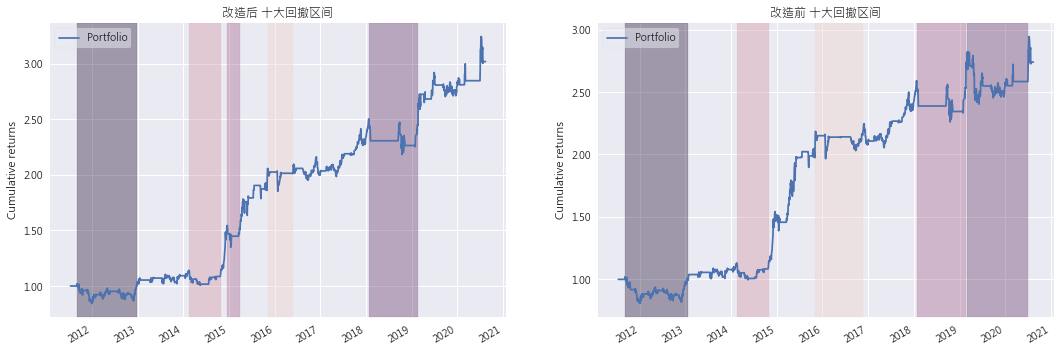

In [26]:
fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(121)

pf.plotting.plot_drawdown_periods(
    algorithm_ret_ver2['RSRS_passivation'], top=5)
ax.set_title('改造后 十大回撤区间')

ax = fig.add_subplot(122)
pf.plotting.plot_drawdown_periods(algorithm_ret['RSRS_passivation'], top=5)
ax.set_title('改造前 十大回撤区间')

结论：改造钝化核心应该在指数项上，使用不同的震荡过滤指标会有不同的效果，从而达到提升收益或者过滤震荡的效果

**附LR指标与HS300的关系图**

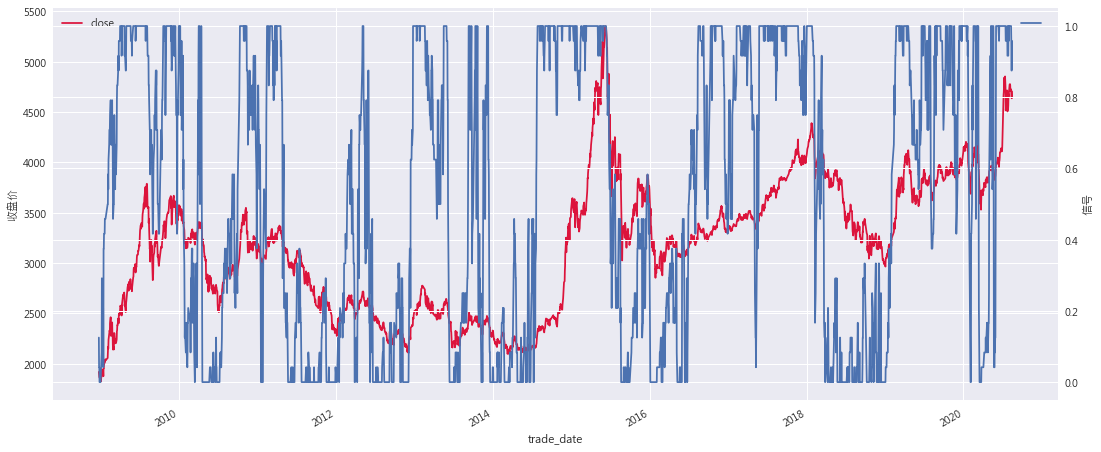

In [29]:
view_signal(price_df['close'],LR)